# Superpixel in Myocardial Histopathological Scanning

In [1]:
# Headers
import geopandas as gpd
import pandas as pd
import numpy as np
from skimage import io
from skimage.draw import polygon
from aicspylibczi import CziFile
from pathlib import Path
import matplotlib.pyplot as plt

## Data Loading

In [2]:
IMAGE_DATA = "/mnt/Imaging/Idrive/Group Fritzsche/Jacky/myocardial cells/For sharing analysis/no097_FR_D30_Q2_MT.czi"
ANNOTATION_GEOJSON = "/mnt/Imaging/Idrive/Group Fritzsche/Jacky/myocardial cells/For sharing analysis/no097_FR_D30_Q2_MT/no097_FR_D30_Q2_MT.czi - Scene #2.geojson"

EXPORT_MASK = "/mnt/Imaging/Idrive/Group Fritzsche/Jacky/myocardial cells/For sharing analysis/no097_FR_D30_Q2_MT/no097_FR_D30_Q2_MT_label.tiff"

SCALE_FACTOR = 0.1

### Load GeoJson Information (Annotation from QuPath)

Load the GeoJson object file from QuOath using [GeoPandas](https://geopandas.org/en/stable/getting_started/introduction.html)

In [3]:
df_object = gpd.read_file(ANNOTATION_GEOJSON)

We have loaded the GeoJson file outputted from QuPath. Let's play around the pandas file.

In [4]:
# Examining content inside
df_object

,id,objectType,classification,isLocked,measurements,geometry
0,89306ddd-f200-4787-ba06-a560c9f5bec9,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 1.132...,"POLYGON ((4520.00000 3299.00000, 4520.00000 34..."
1,4cd2b4c8-07f9-457f-8181-191834b6cf51,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 1.456...,"POLYGON ((12317.00000 5446.00000, 12317.00000 ..."
2,40c707d2-fec1-408f-b6a7-c4ec9a9f7e0b,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 1.585...,"POLYGON ((14916.00000 6350.00000, 14916.00000 ..."
3,22cc3c31-24eb-4037-9467-fe1890070ef6,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.497...,"MULTIPOLYGON (((18016.00000 13243.00000, 18016..."
4,acc16526-4823-48eb-adea-34a31d07ee89,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.034...,"MULTIPOLYGON (((7360.00000 16746.00000, 7360.0..."
...,...,...,...,...,...,...
73,4699ac71-9d5b-4d9e-a612-05bef43e1b52,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.441...,"MULTIPOLYGON (((5989.00000 4640.00000, 6016.00..."
74,2c733280-2aad-47b1-8c0c-eaf636d3e029,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.623...,"POLYGON ((20227.00000 13695.00000, 20227.00000..."
75,e867d964-8215-4770-bd42-246c87cfe702,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.156...,"MULTIPOLYGON (((18080.00000 22688.00000, 18176..."
76,02b9b559-e8c4-4be9-b539-0184e10a33db,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.104...,"MULTIPOLYGON (((20288.00000 8158.00000, 20288...."


`Measurement` column is a dictionary of measured values from QuPath. Convert to Pandas format for later handling.

In [5]:
df_measurements = df_object.measurements.apply(pd.Series)

In [6]:
df_measurements

,ROI: 2.00 µm per pixel: OD Sum: Mean,ROI: 2.00 µm per pixel: OD Sum: Std.dev.,ROI: 2.00 µm per pixel: OD Sum: Min,ROI: 2.00 µm per pixel: OD Sum: Max,ROI: 2.00 µm per pixel: OD Sum: Median,ROI: 2.00 µm per pixel: OD Sum: Haralick Angular second moment (F0),ROI: 2.00 µm per pixel: OD Sum: Haralick Contrast (F1),ROI: 2.00 µm per pixel: OD Sum: Haralick Correlation (F2),ROI: 2.00 µm per pixel: OD Sum: Haralick Sum of squares (F3),ROI: 2.00 µm per pixel: OD Sum: Haralick Inverse difference moment (F4),...,ROI: 2.00 µm per pixel: Residual: Haralick Sum of squares (F3),ROI: 2.00 µm per pixel: Residual: Haralick Inverse difference moment (F4),ROI: 2.00 µm per pixel: Residual: Haralick Sum average (F5),ROI: 2.00 µm per pixel: Residual: Haralick Sum variance (F6),ROI: 2.00 µm per pixel: Residual: Haralick Sum entropy (F7),ROI: 2.00 µm per pixel: Residual: Haralick Entropy (F8),ROI: 2.00 µm per pixel: Residual: Haralick Difference variance (F9),ROI: 2.00 µm per pixel: Residual: Haralick Difference entropy (F10),ROI: 2.00 µm per pixel: Residual: Haralick Information measure of correlation 1 (F11),ROI: 2.00 µm per pixel: Residual: Haralick Information measure of correlation 2 (F12)
0,1.132277,0.656412,0.000000,2.864679,1.3195,0.017457,12.656726,0.909354,69.840370,0.436974,...,0.006391,0.995974,0.004813,0.009579,0.020879,0.099879,0.030735,0.067508,-0.219013,0.154453
1,1.456622,0.767715,0.002083,2.969183,1.7785,0.019283,12.648293,0.934496,96.541512,0.477190,...,0.014608,0.991151,0.011837,0.023624,0.043998,0.197616,0.030131,0.128507,-0.214196,0.212956
2,1.585366,0.492634,0.002083,3.894596,1.7085,0.013516,8.267550,0.894855,39.351128,0.443226,...,0.193290,0.907995,0.333289,0.467828,0.443303,1.475860,0.021604,0.686757,-0.224376,0.552294
3,0.497517,0.424419,0.000000,1.800113,0.5305,0.078883,4.251871,0.923885,27.965052,0.581292,...,0.000607,0.999652,0.000518,0.001035,0.003044,0.012317,0.031205,0.008203,-0.332615,0.066033
4,0.034900,0.149634,0.000000,1.670569,0.0065,0.884783,0.660357,0.888128,2.913196,0.957411,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.441598,0.634711,0.000000,2.624051,0.0385,0.250389,8.632751,0.933435,64.739716,0.669443,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,NaN,0.000000
74,0.623396,0.384010,0.000000,2.869798,0.6075,0.012023,5.581501,0.883637,23.989475,0.490031,...,0.000290,0.999767,0.000114,0.000228,0.000800,0.007185,0.031220,0.005836,-0.124472,0.030352
75,0.156612,0.226569,0.000000,1.905190,0.0665,0.205309,3.387825,0.794012,8.201366,0.702242,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,NaN,0.000000
76,0.104919,0.325102,0.000000,1.854949,0.0105,0.656391,3.829124,0.867058,14.364949,0.871277,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,NaN,0.000000


Joining back to original dataframe

In [7]:
df_object = pd.concat([df_object, df_measurements], axis=1)

In [8]:
df_object

,id,objectType,classification,isLocked,measurements,geometry,ROI: 2.00 µm per pixel: OD Sum: Mean,ROI: 2.00 µm per pixel: OD Sum: Std.dev.,ROI: 2.00 µm per pixel: OD Sum: Min,ROI: 2.00 µm per pixel: OD Sum: Max,...,ROI: 2.00 µm per pixel: Residual: Haralick Sum of squares (F3),ROI: 2.00 µm per pixel: Residual: Haralick Inverse difference moment (F4),ROI: 2.00 µm per pixel: Residual: Haralick Sum average (F5),ROI: 2.00 µm per pixel: Residual: Haralick Sum variance (F6),ROI: 2.00 µm per pixel: Residual: Haralick Sum entropy (F7),ROI: 2.00 µm per pixel: Residual: Haralick Entropy (F8),ROI: 2.00 µm per pixel: Residual: Haralick Difference variance (F9),ROI: 2.00 µm per pixel: Residual: Haralick Difference entropy (F10),ROI: 2.00 µm per pixel: Residual: Haralick Information measure of correlation 1 (F11),ROI: 2.00 µm per pixel: Residual: Haralick Information measure of correlation 2 (F12)
0,89306ddd-f200-4787-ba06-a560c9f5bec9,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 1.132...,"POLYGON ((4520.00000 3299.00000, 4520.00000 34...",1.132277,0.656412,0.000000,2.864679,...,0.006391,0.995974,0.004813,0.009579,0.020879,0.099879,0.030735,0.067508,-0.219013,0.154453
1,4cd2b4c8-07f9-457f-8181-191834b6cf51,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 1.456...,"POLYGON ((12317.00000 5446.00000, 12317.00000 ...",1.456622,0.767715,0.002083,2.969183,...,0.014608,0.991151,0.011837,0.023624,0.043998,0.197616,0.030131,0.128507,-0.214196,0.212956
2,40c707d2-fec1-408f-b6a7-c4ec9a9f7e0b,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 1.585...,"POLYGON ((14916.00000 6350.00000, 14916.00000 ...",1.585366,0.492634,0.002083,3.894596,...,0.193290,0.907995,0.333289,0.467828,0.443303,1.475860,0.021604,0.686757,-0.224376,0.552294
3,22cc3c31-24eb-4037-9467-fe1890070ef6,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.497...,"MULTIPOLYGON (((18016.00000 13243.00000, 18016...",0.497517,0.424419,0.000000,1.800113,...,0.000607,0.999652,0.000518,0.001035,0.003044,0.012317,0.031205,0.008203,-0.332615,0.066033
4,acc16526-4823-48eb-adea-34a31d07ee89,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.034...,"MULTIPOLYGON (((7360.00000 16746.00000, 7360.0...",0.034900,0.149634,0.000000,1.670569,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,4699ac71-9d5b-4d9e-a612-05bef43e1b52,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.441...,"MULTIPOLYGON (((5989.00000 4640.00000, 6016.00...",0.441598,0.634711,0.000000,2.624051,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,NaN,0.000000
74,2c733280-2aad-47b1-8c0c-eaf636d3e029,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.623...,"POLYGON ((20227.00000 13695.00000, 20227.00000...",0.623396,0.384010,0.000000,2.869798,...,0.000290,0.999767,0.000114,0.000228,0.000800,0.007185,0.031220,0.005836,-0.124472,0.030352
75,e867d964-8215-4770-bd42-246c87cfe702,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.156...,"MULTIPOLYGON (((18080.00000 22688.00000, 18176...",0.156612,0.226569,0.000000,1.905190,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,NaN,0.000000
76,02b9b559-e8c4-4be9-b539-0184e10a33db,tile,NaN,NaN,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.104...,"MULTIPOLYGON (((20288.00000 8158.00000, 20288....",0.104919,0.325102,0.000000,1.854949,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,NaN,0.000000


Plot a single object

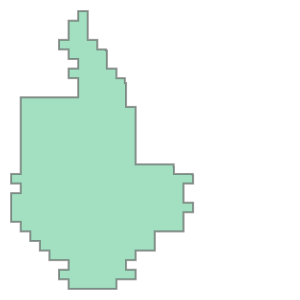

In [9]:
df_object['geometry'][0]

Look up the tissue segmention region with Object ID	`16c56a7c-16b1-4c0a-886c-d82cc564c9fe`

In [10]:
TISSUE_ID = '16c56a7c-16b1-4c0a-886c-d82cc564c9fe'

df_object.loc[df_object['id'] == TISSUE_ID].reset_index()

,index,id,objectType,classification,isLocked,measurements,geometry,ROI: 2.00 µm per pixel: OD Sum: Mean,ROI: 2.00 µm per pixel: OD Sum: Std.dev.,ROI: 2.00 µm per pixel: OD Sum: Min,...,ROI: 2.00 µm per pixel: Residual: Haralick Sum of squares (F3),ROI: 2.00 µm per pixel: Residual: Haralick Inverse difference moment (F4),ROI: 2.00 µm per pixel: Residual: Haralick Sum average (F5),ROI: 2.00 µm per pixel: Residual: Haralick Sum variance (F6),ROI: 2.00 µm per pixel: Residual: Haralick Sum entropy (F7),ROI: 2.00 µm per pixel: Residual: Haralick Entropy (F8),ROI: 2.00 µm per pixel: Residual: Haralick Difference variance (F9),ROI: 2.00 µm per pixel: Residual: Haralick Difference entropy (F10),ROI: 2.00 µm per pixel: Residual: Haralick Information measure of correlation 1 (F11),ROI: 2.00 µm per pixel: Residual: Haralick Information measure of correlation 2 (F12)
0,62,16c56a7c-16b1-4c0a-886c-d82cc564c9fe,annotation,"{'name': 'Tissue', 'color': [83, 47, 31]}",True,{'ROI: 2.00 µm per pixel: OD Sum: Mean': 0.940...,"MULTIPOLYGON (((160.00000 16160.00000, 160.000...",0.940674,0.692857,0.0,...,0.020029,0.992461,0.02522,0.050471,0.080864,0.224728,0.030293,0.112859,-0.417336,0.333542


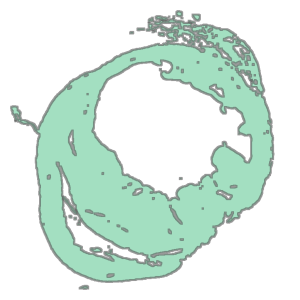

In [11]:
df_object.loc[df_object['id'] == TISSUE_ID].reset_index()['geometry'][0]

Plot the superpixel regions and the tissue boundaries.

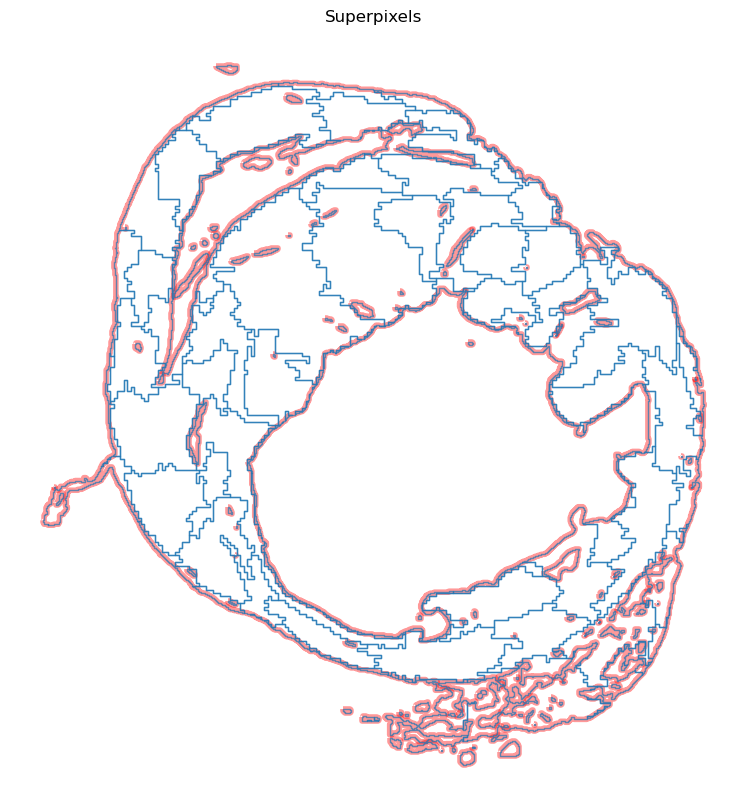

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_axis_off()
ax.set_title("Superpixels")

df_object.loc[df_object['id'] == TISSUE_ID].boundary.plot(ax=ax,color='r',linewidth=4,alpha=0.4)
df_object.loc[df_object['id'] != TISSUE_ID].boundary.plot(ax=ax,linewidth=1,alpha=0.7)
ax.set_aspect('equal')

# The y coordinate is inverted for display coordinate, now flip it over
ax.invert_yaxis()

We have got some measurements from QuPath, let's check with color map overlay.

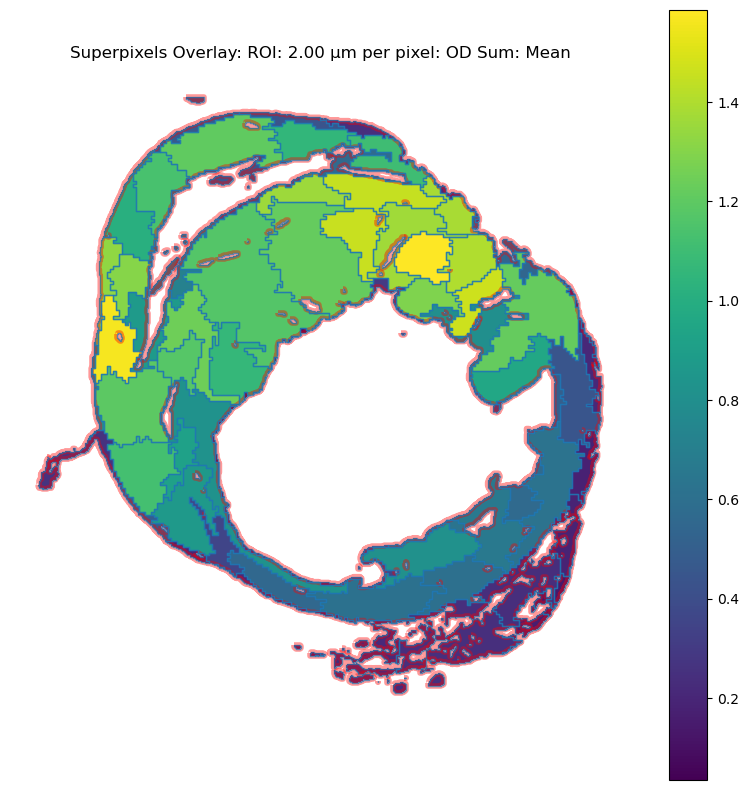

In [13]:
MEASUREMENT_DISP = "ROI: 2.00 µm per pixel: OD Sum: Mean"

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_axis_off()
ax.set_title("Superpixels Overlay: {}".format(MEASUREMENT_DISP))

df_object.loc[df_object['id'] != TISSUE_ID].plot(column=MEASUREMENT_DISP,ax=ax, legend=True)
df_object.loc[df_object['id'] == TISSUE_ID].boundary.plot(ax=ax,color='r',linewidth=4,alpha=0.4)
df_object.loc[df_object['id'] != TISSUE_ID].boundary.plot(ax=ax,linewidth=1,alpha=0.7)
ax.set_aspect('equal')

# The y coordinate is inverted for display coordinate, now flip it over
ax.invert_yaxis()

### Load Image File

For quick CZI image IO, use [aicspylibczi](https://github.com/AllenCellModeling/aicspylibczi)

In [14]:
# Read the original image
pth = Path(IMAGE_DATA)
czi = CziFile(pth)

# Get the shape of the data, the coordinate pairs are (start index, size)
print("Dimensions:", czi.get_dims_shape())
print("Dimension Order: ", czi.dims)
print("Is Mosaic:", czi.is_mosaic())

Dimensions: [{'A': (0, 3), 'X': (0, 1600), 'Y': (0, 1200), 'C': (0, 1), 'M': (0, 300), 'S': (0, 1)}, {'A': (0, 3), 'X': (0, 1600), 'Y': (0, 1200), 'C': (0, 1), 'M': (0, 270), 'S': (1, 2)}]
Dimension Order:  SCMYXA
Is Mosaic: True


In [15]:
images = []
# full resolution loading for two scenes takes about 1.5mins, for quick debug we use scale factor of 0.1

for s, bbox in czi.get_all_mosaic_scene_bounding_boxes().items():
    print("Mosaic Scene {} Bounding Box (X,Y,W,H):".format(s),bbox.x,bbox.y,bbox.w,bbox.h)

    # read the specific part of the CZI
    # Mosaic files ignore the S dimension and use an internal mIndex to reconstruct, the scale factor allows one to generate a manageable image
    data = czi.read_mosaic(region=(bbox.x, bbox.y, bbox.w, bbox.h), scale_factor=SCALE_FACTOR, C=0)

    images.append(
        {
            "scence":s,
            "data":data,
            "bbox":bbox
        }
    )

    # the C channel has been specified S & M are used internally for position so this is (?, Y, X, A), here A is for channel purpose but typically it is sample
    print("Numpy image shape:",data.shape)


Mosaic Scene 0 Bounding Box (X,Y,W,H): -207383 47520 24670 24978
Numpy image shape: (1, 2497, 2467, 3)
Mosaic Scene 1 Bounding Box (X,Y,W,H): -115234 38880 23224 24953
Numpy image shape: (1, 2495, 2322, 3)


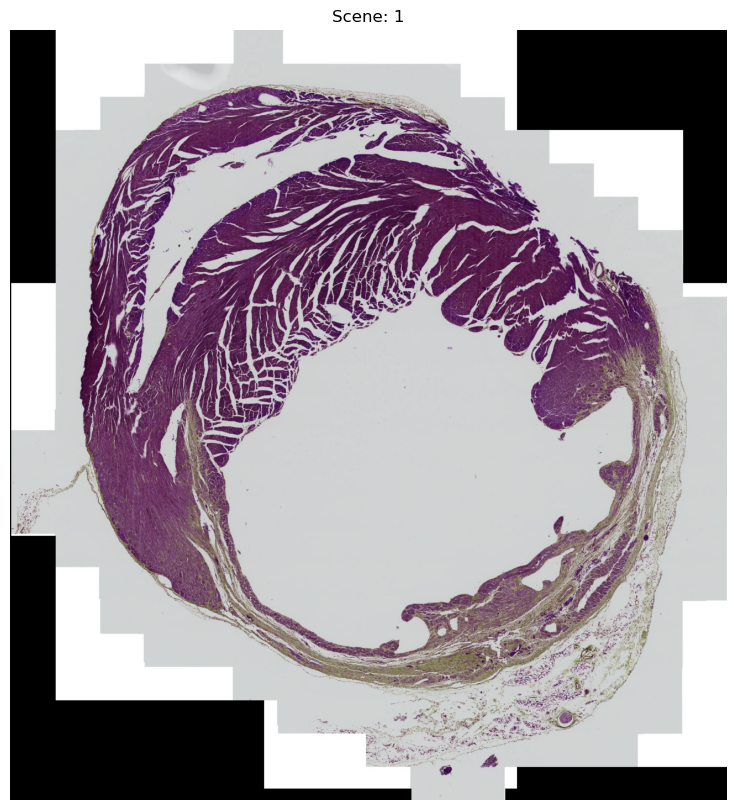

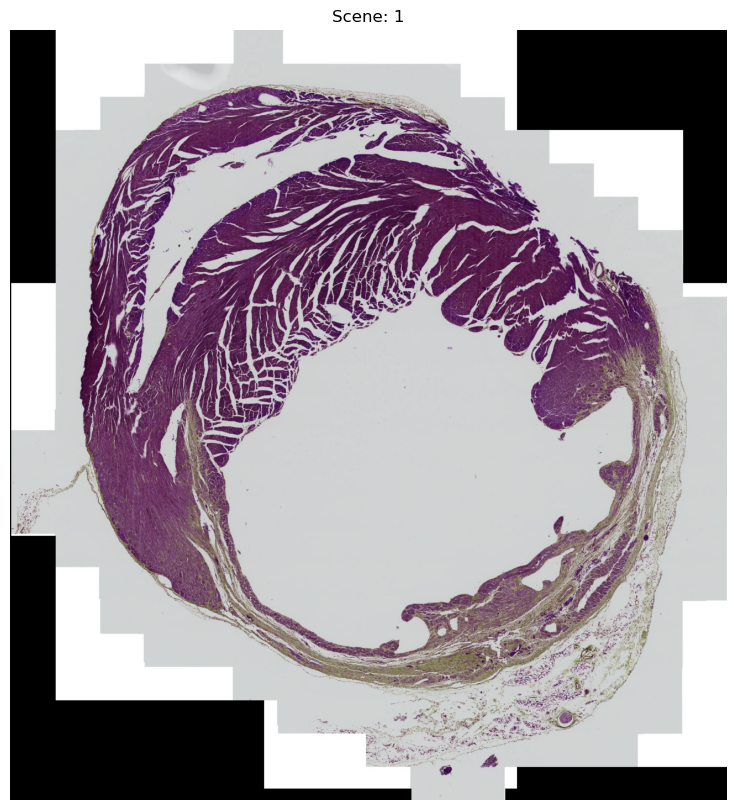

In [16]:
# plot the data
for image in images:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title("Scene: {}".format(s))
    ax.imshow(data[0,])
    ax.set_axis_off()

## Overlaying Superpixels on Brightfield

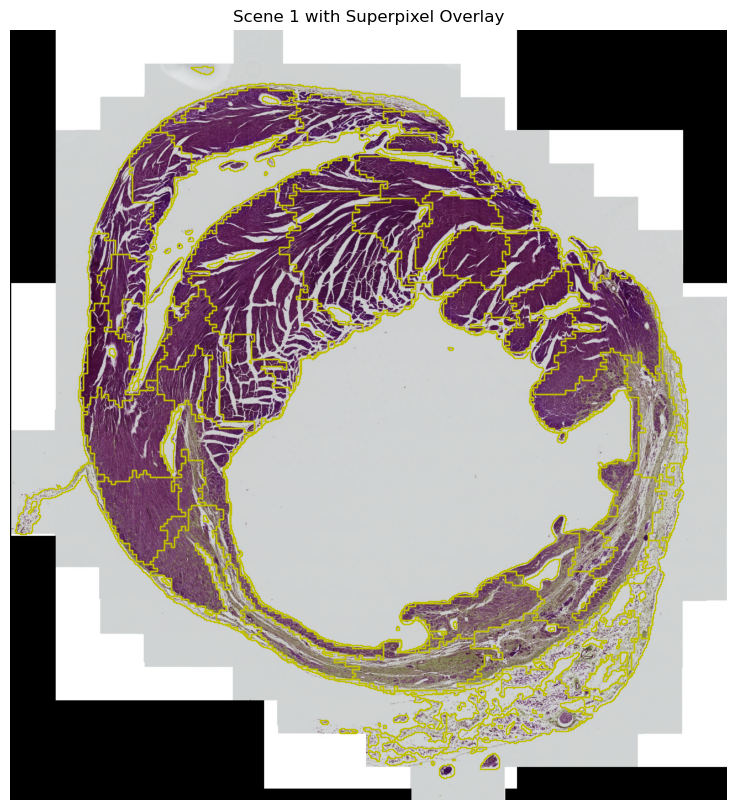

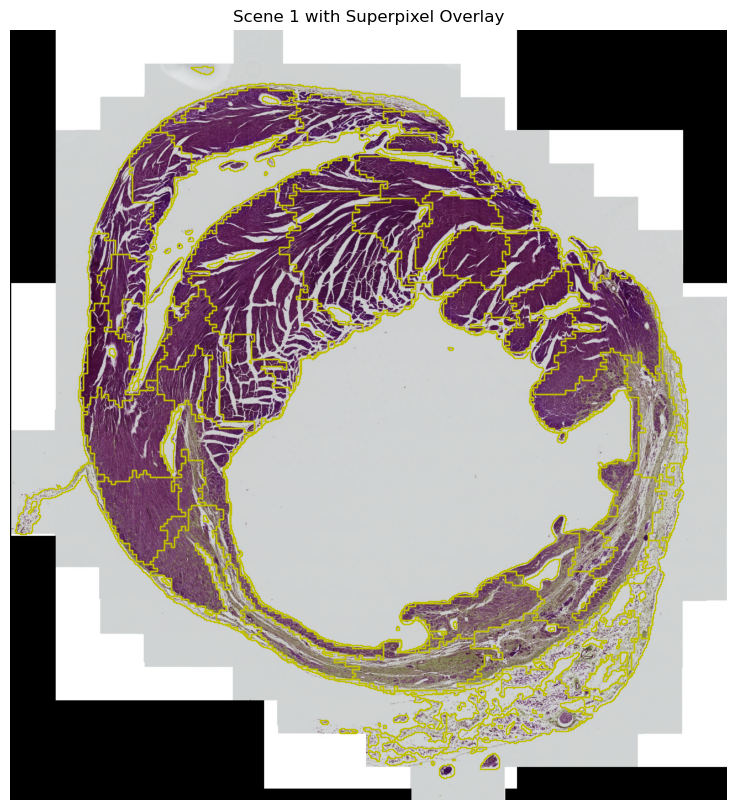

In [24]:
# plot the data with superpixel overlay
for image in images:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title("Scene {} with Superpixel Overlay".format(s))
    axIm = ax.imshow(data[0,])
    ax.set_axis_off()
    axIm.set_extent(np.array(axIm.get_extent())/SCALE_FACTOR)
    df_object.loc[df_object['id'] != TISSUE_ID].boundary.plot(ax=ax,linewidth=1,alpha=1.0,color="y")
    ax.set_aspect('equal')
    ax.autoscale(False)